In [14]:
import requests
import pandas
import numpy
import matplotlib.pyplot as plt
import statistics
# import seaborn as sns

league_id = 3360585
year = 2019
url = "https://fantasy.espn.com/apis/v3/games/ffl/leagueHistory/" + \
      str(league_id) + "?seasonId=" + str(year)

r = requests.get(url)
d = r.json()[0]

ids = []
names = []

for team in d['teams']:
    ids.append(team['id'])
    names.append(team['location'] + " " + team['nickname'])

dictionary = {"Name":names, "ID":ids}

ref = pandas.DataFrame(dictionary)

In [2]:
r = requests.get(url, params={"view": "mMatchup"})
d = r.json()[0]

In [3]:
df = [[
        game['matchupPeriodId'],
        game['home']['teamId'], game['home']['totalPoints'],
        game['away']['teamId'], game['away']['totalPoints']
    ] for game in d['schedule']]
df = pandas.DataFrame(df, columns=['Week', 'Team1', 'Score1', 'Team2', 'Score2'])

df.drop([60,61,62,63,64,65,66,67,68,69], inplace=True)
df.head()

,Week,Team1,Score1,Team2,Score2
0,1,5,119.15,9,101.20
1,1,1,101.30,2,101.20
2,1,3,108.45,6,115.75
3,1,4,154.65,7,112.00
4,1,10,132.00,8,122.30


In [4]:
def get_team_name(id):
    temp = ref[ref['ID'] == id]
    name = temp.iloc[0]['Name']
    return name

In [15]:
a = (df['Score1'].mean() + df['Score2'].mean()) / 2
print("The average weekly score across the league was", round(a, 2), "points")

The average weekly score across the league was 108.61 points


In [16]:
# find the highest single week score by a team
s1 = df['Score1'].max()
s2 = df['Score2'].max()

if s1 > s2:
    temp = df[df['Score1'] == s1]
    team_id = temp.iloc[0]['Team1']
    week = temp.iloc[0]['Week']
    team_name = get_team_name(team_id)
    print("The highest score by a single team in the league was", s1, "by the", team_name, "in week", week)
else:
    temp = df[df['Score2'] == s2]
    team_id = temp.iloc[0]['Team2']
    week = temp.iloc[0]['Week']
    team_name = get_team_name(team_id)
    print("The highest score by a single team in the league was", s2, "by the", team_name, "in week", week)

The highest score by a single team in the league was 173.8 by the Bellarmine Bombers in week 8.0


In [17]:
# find the lowest single week score by a team
s1 = df['Score1'].min()
s2 = df['Score2'].min()

if s1 < s2:
    temp = df[df['Score1'] == s1]
    team_id = temp.iloc[0]['Team1']
    week = temp.iloc[0]['Week']
    team_name = get_team_name(team_id)
    print("The lowest score by a single team in the league was", s1, "by the", team_name, "in week", week)
else:
    temp = df[df['Score2'] == s2]
    team_id = temp.iloc[0]['Team2']
    week = temp.iloc[0]['Week']
    team_name = get_team_name(team_id)
    print("The lowest score by a single team in the league was", s2, "by the", team_name, "in week", week)

The lowest score by a single team in the league was 61.55 by the King of New York in week 7.0


Next I want to find which team's scores were the most consistent from week to week. In other words, which team's scores from week to week deviated the least.

In [23]:
standard_deviations = []

tm = 1
while tm <= 10:
    scores = []
    temp = df.loc[(df['Team1'] == tm) | (df['Team2'] == tm)]
    i = 0
    while i < len(temp.index):
        if temp.iloc[i]['Team1'] == tm:
            scores.append(temp.iloc[i]['Score1'])
        else:
            scores.append(temp.iloc[i]['Score2'])
        i+=1
    standard_deviations.append(statistics.stdev(scores))
    tm+=1
ref['Stdevs'] = standard_deviations
min_stdev = min(standard_deviations)
max_stdev = max(standard_deviations)

temp = ref[ref['Stdevs'] == min_stdev]
team_name = temp.iloc[0]['Name']

print("The team who scored the most consistently from week to week was", team_name, "with a stdev of", round(min_stdev, 2), "points")
print("The stdevs for each team can be seen below. Higher deviations indicate less consistency in score from week to week, while lower indicates greater consistency")
print(ref[['ID', 'Stdevs']])

The team who scored the most consistently from week to week was The New York Dons with a stdev of 12.61 points
The stdevs for each team can be seen below. Higher deviations indicate less consistency in score from week to week, while lower indicates greater consistency
   ID     Stdevs
0   1  18.480376
1   2  22.602388
2   3  21.829635
3   4  27.967834
4   5  28.077135
5   6  17.559101
6   7  12.614028
7   8  31.101472
8   9  27.933667
9  10  27.947397


In [9]:
df3 = df.assign(Margin1 = df['Score1'] - df['Score2'],
                Margin2 = df['Score2'] - df['Score1'])
df3 = (df3[['Week', 'Team1', 'Margin1']]
 .rename(columns={'Team1': 'Team', 'Margin1': 'Margin'})
 .append(df3[['Week', 'Team2', 'Margin2']]
 .rename(columns={'Team2': 'Team', 'Margin2': 'Margin'}))
)
df3.head(100)

,Week,Team,Margin
0,1,5,17.95
1,1,1,0.10
2,1,3,-7.30
3,1,4,42.65
4,1,10,9.70
...,...,...,...
35,8,4,77.60
36,8,1,-9.30
37,8,5,2.80
38,8,9,4.75


In [10]:
avgs = (df
 .filter(['Week', 'Score1', 'Score2'])
 .melt(id_vars=['Week'], value_name='Score')
 .groupby('Week')
 .mean()
 .reset_index()
)

,Week,Score
0,1,116.800
1,2,99.945
2,3,123.030
3,4,98.080
4,5,121.975


Now, I want to find the "luckiest" win and the "unluckiest" loss that occurred in the season. A "lucky" win means that you scored worse than the rest of the league that week, but still managed to win. An "unlucky" loss mean a team scored better than most of the league that week, but still managed to lose. To calculate this, I'm going to take the average score across the league for each week then compare all of the losing team's scores to it to determine who was the "unluckiest", and vice versa for the "luckiest".

In [11]:
wins = []
losses = []
tracking = []

frames = []

tm = 1
while tm < 11:
    temp = []
    # grab all games with this team
    df2 = df.query('Team1 == @tm | Team2 == @tm').reset_index(drop=True)

    # move the team of interest to "Team1" column
    ix = list(df2['Team2'] == tm)
    df2.loc[ix, ['Team1','Score1','Team2','Score2']] = \
        df2.loc[ix, ['Team2','Score2','Team1','Score1']].values

    # add new score and win cols
    df2 = (df2
     .assign(Chg1 = df2['Score1'] - avgs['Score'],
             Chg2 = df2['Score2'] - avgs['Score'],
             Win  = df2['Score1'] > df2['Score2'])
    )
    
    #calculate win/loss
    w = 0
    l = 0
    for result in df2['Win']:
        if result == True:
            w+=1
        else:
            l+=1
        temp.append(w)
    wins.append(w)
    losses.append(l)
    tracking.append(temp)
    
    tm+=1
    
    frames.append(df2)

df2.head(100)

,Week,Team1,Score1,Team2,Score2,Chg1,Chg2,Win
0,1,10.0,132.00,8.0,122.30,15.200,5.500,True
1,2,10.0,99.05,3.0,80.55,-0.895,-19.395,True
2,3,10.0,80.75,6.0,145.20,-42.280,22.170,False
3,4,10.0,89.60,4.0,66.40,-8.480,-31.680,True
4,5,10.0,153.80,2.0,122.50,31.825,0.525,True
5,6,10.0,109.80,1.0,130.20,2.600,23.000,False
6,7,10.0,91.50,5.0,78.55,-1.495,-14.445,True
7,8,10.0,106.25,9.0,111.00,-17.800,-13.050,False
8,9,10.0,151.25,4.0,68.80,46.310,-36.140,True
9,10,10.0,139.20,1.0,103.55,29.315,-6.335,True


In [27]:
ref["Wins"] = wins
ref["Losses"] = losses
print(ref[['ID', 'Wins', 'Losses']])

   ID  Wins  Losses
0   1     6       6
1   2     4       8
2   3     5       7
3   4     4       8
4   5    11       1
5   6     9       3
6   7     6       6
7   8     3       9
8   9     4       8
9  10     8       4


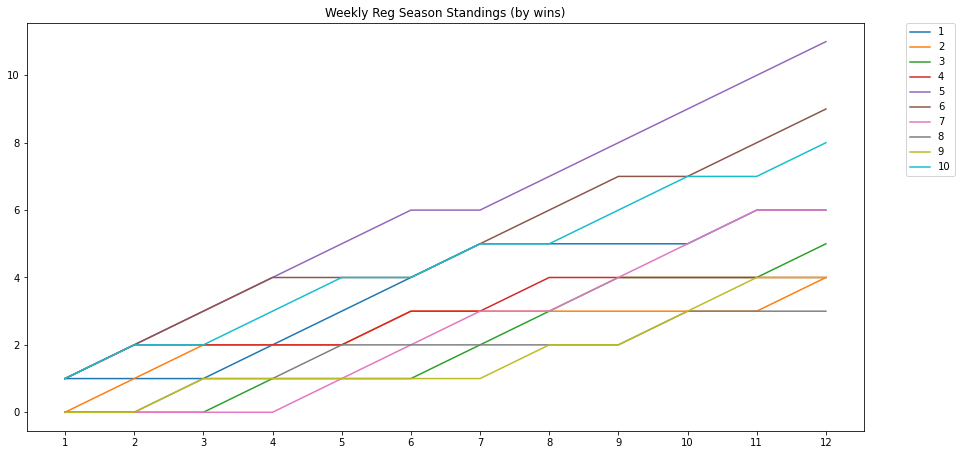

In [26]:
x_ax = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

i = 0
plt.figure(figsize=(15,7.5))
for list in tracking:
    plt.plot(x_ax, list, label = ref['ID'][i])
    i+=1
plt.xticks(numpy.arange(min(x_ax), max(x_ax)+1, 1.0))
plt.title("Weekly Reg Season Standings (by wins)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()